##UCSD anomaly detection with convolutional autoencoder

# 🚀 UCSD Anomaly Detection with Convolutional Autoencoder (PyTorch)

This notebook shows how to detect anomalies in video surveillance data  
using a convolutional autoencoder (CAE) trained only on normal data.

We use the **UCSD Ped2 dataset** (pedestrian walkways) where anomalies include bikes and vehicles.

By learning to reconstruct normal frames, the CAE will produce higher reconstruction errors for anomalous frames.

*Framework*: PyTorch  



## 📦 Step 1: Import necessary libraries

We'll import PyTorch, OpenCV for image loading, numpy, matplotlib for plotting,  
and tqdm for progress bars.


In [1]:
# Install libraries if using Colab (uncomment if needed)
# !pip install torch torchvision numpy opencv-python matplotlib tqdm

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)



Using device: cpu


## 📂 Step 2: Load and preprocess UCSD Ped2 dataset

We'll load grayscale frames, resize them to 64×64, and normalize pixel values to [0,1].



In [4]:
import tarfile

tar_path = '/content/drive/MyDrive/UCSD_Anomaly_Dataset.tar.gz'

with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path='/content/')



In [5]:
train_folder = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train'
test_folder = '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test'

def load_ucsd_frames(folder, resize_shape=(64,64)):
    frames = []
    all_videos = sorted(glob(folder + '/*'))
    for video in tqdm(all_videos, desc=f'Loading {folder}'):
        img_files = sorted(glob(video + '/*.tif'))
        for img_path in img_files:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, resize_shape)
            frames.append(img / 255.0)
    return np.array(frames, dtype=np.float32)

X_train = load_ucsd_frames(train_folder)
X_test = load_ucsd_frames(test_folder)

print('Train frames:', X_train.shape)
print('Test frames:', X_test.shape)


Loading /content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train: 100%|██████████| 16/16 [00:01<00:00,  9.83it/s]
Loading /content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test: 100%|██████████| 26/26 [00:01<00:00, 20.95it/s]

Train frames: (2550, 64, 64)
Test frames: (2010, 64, 64)


## 🖼️ Step 3: Visualize some training frames

Let's look at a few sample frames to verify that data loading works correctly.


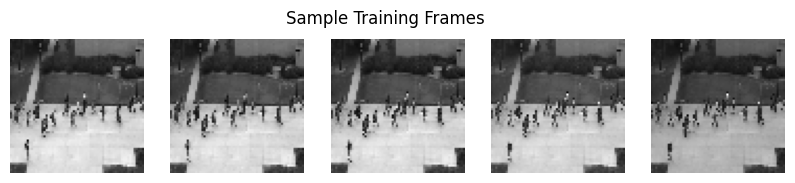

In [6]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Training Frames')
plt.show()


## 🧠 Step 4: Build the convolutional autoencoder

We'll define an encoder that compresses frames and a decoder that reconstructs them.

Since we only train on normal data, the CAE should learn normal patterns.


In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B,16,32,32]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B,32,16,16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B,64,8,8]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # [B,32,16,16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # [B,16,32,32]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [B,1,64,64]
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ConvAutoencoder().to(device)
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


## 🏋️‍♂️ Step 5: Train the autoencoder on normal frames

We train with mean squared error loss to reconstruct frames.

After training, the autoencoder should have low reconstruction error on normal frames.


In [8]:
X_train_tensor = torch.tensor(X_train).unsqueeze(1).to(device)  # shape [N,1,64,64]

batch_size = 64
num_epochs = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = len(X_train_tensor) // batch_size
    for i in range(num_batches):
        batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


Epoch [1/20], Loss: 0.028195
Epoch [2/20], Loss: 0.013014
Epoch [3/20], Loss: 0.006329
Epoch [4/20], Loss: 0.003944
Epoch [5/20], Loss: 0.003205
Epoch [6/20], Loss: 0.002832
Epoch [7/20], Loss: 0.002591
Epoch [8/20], Loss: 0.002438
Epoch [9/20], Loss: 0.002323
Epoch [10/20], Loss: 0.002239
Epoch [11/20], Loss: 0.002161
Epoch [12/20], Loss: 0.002095
Epoch [13/20], Loss: 0.002033
Epoch [14/20], Loss: 0.001976
Epoch [15/20], Loss: 0.001921
Epoch [16/20], Loss: 0.001867
Epoch [17/20], Loss: 0.001811
Epoch [18/20], Loss: 0.001758
Epoch [19/20], Loss: 0.001711
Epoch [20/20], Loss: 0.001670


## 📉 Step 6: Plot training loss curve

Visualize how the loss decreases over epochs.


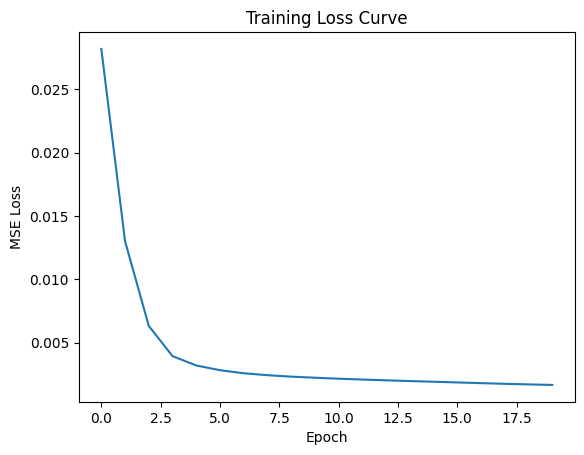

In [9]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.show()


## 🔍 Step 7: Compute reconstruction errors on test frames

Frames with high reconstruction error are likely anomalous.


In [10]:
model.eval()
X_test_tensor = torch.tensor(X_test).unsqueeze(1).to(device)

with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = ((X_test_tensor - reconstructed) ** 2).mean(dim=[1,2,3]).cpu().numpy()

print('Reconstruction error shape:', reconstruction_error.shape)


Reconstruction error shape: (2010,)


## 📊 Step 8: Plot reconstruction error as anomaly score

Peaks in the curve indicate frames where the model failed to reconstruct well → possible anomalies.


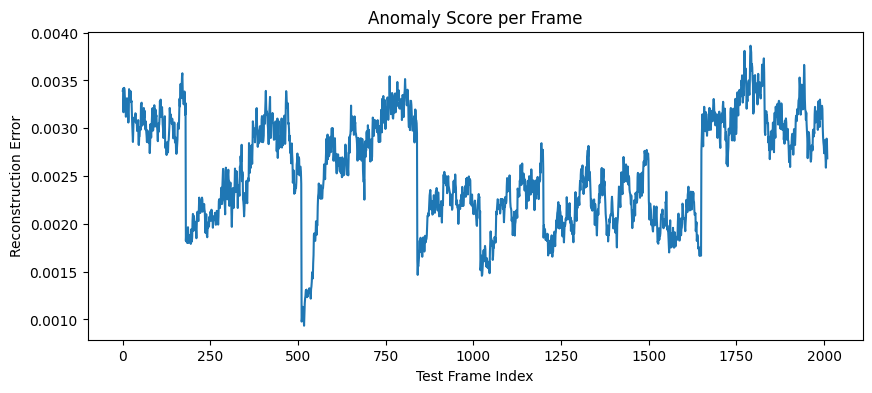

In [11]:
plt.figure(figsize=(10,4))
plt.plot(reconstruction_error)
plt.xlabel('Test Frame Index')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Score per Frame')
plt.show()


## 🖼️ Step 9: Visualize original vs reconstructed frames

We compare original test frames with their reconstructions.  
Large differences often correspond to anomalies.


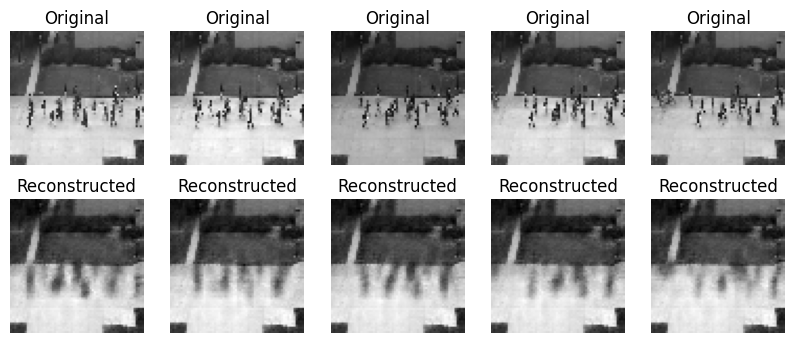

In [12]:
n = 5
plt.figure(figsize=(10,4))
for i in range(n):
    idx = i*20
    plt.subplot(2,n,i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2,n,i+1+n)
    rec_img = reconstructed[idx].cpu().squeeze().numpy()
    plt.imshow(rec_img, cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()


## 🎬 Step 10: Create professional animation of anomaly detection

In this step, we generate an animation with four panels:
- **Input image**: Original test frame
- **Reconstructed image**: Autoencoder output
- **Difference**: Reconstruction error (highlighted)
- **Anomalies**: Areas where the model struggles to reconstruct, overlaid on the frame

This visualization helps clearly see where anomalies happen.


In [22]:
import cv2
import numpy as np
from tqdm import tqdm

frames_for_gif = []

threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)

for i in tqdm(range(len(X_test))):
    original = (X_test[i] * 255).astype(np.uint8)
    recon = (reconstructed[i] * 255).astype(np.uint8)

    diff = cv2.absdiff(original, recon)
    anomaly_mask = (diff > (np.mean(diff) + 2*np.std(diff))).astype(np.uint8) * 255
    anomaly_overlay = cv2.addWeighted(recon, 0.7, anomaly_mask, 0.3, 0)
    diff_colored = cv2.applyColorMap(diff, cv2.COLORMAP_JET)

    def add_label(img, label):
        return cv2.putText(img.copy(), label, (5,15),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    original_labeled = add_label(cv2.cvtColor(original, cv2.COLOR_GRAY2BGR), 'Input image')
    recon_labeled = add_label(cv2.cvtColor(recon, cv2.COLOR_GRAY2BGR), 'Reconstructed image')
    diff_labeled = add_label(diff_colored, 'Difference')
    anomaly_labeled = add_label(cv2.cvtColor(anomaly_overlay, cv2.COLOR_GRAY2BGR), 'Anomalies')

    combined = np.hstack([original_labeled, recon_labeled, diff_labeled, anomaly_labeled])

    # 📌 Upscale: e.g., double the height/width for clarity
    upscale_factor = 4  # adjust to control final size
    height, width = combined.shape[:2]
    combined_upscaled = cv2.resize(combined, (width * upscale_factor, height * upscale_factor), interpolation=cv2.INTER_NEAREST)

    frames_for_gif.append(combined_upscaled)

print(f"✅ Total frames prepared: {len(frames_for_gif)}")


100%|██████████| 2010/2010 [00:05<00:00, 386.92it/s]

✅ Total frames prepared: 2010


## 📽 Step 12: Save the animation as GIF

We save the side-by-side frames as a GIF file to easily share and view.


In [23]:
import imageio

output_gif = 'anomaly_detection_animation.gif'

# Convert frames to RGB before saving
frames_rgb = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames_for_gif]

# Save GIF at ~10 fps
imageio.mimsave(output_gif, frames_rgb, fps=10)

print("✅ GIF saved:", output_gif)


✅ GIF saved: anomaly_detection_animation.gif


In [25]:
from IPython.display import Image

Image(output_gif)
